In [1]:
#Import des libraires 
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\Users\yahya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
#Reading poloniex api, period is in seconds, start is timestamp for 1/1/2017, pair is USDT ETH.
pair = "USDT_ETH"
start = "1483228800"
period = "300"

print('On charge data')
#Since the API gives a json file we directly transform it to pandas dataframe.
#ajouter convert_date pour parser automatiquement les dates
df = pd.read_json("https://poloniex.com/public?command=returnChartData&currencyPair="+pair+"&start="+start+"&end=9999999999&period="+period,convert_dates=['date'])

On charge data


In [8]:
#mettre la date en index, panads comprend que c'est une timeseries
df=df.set_index('date')

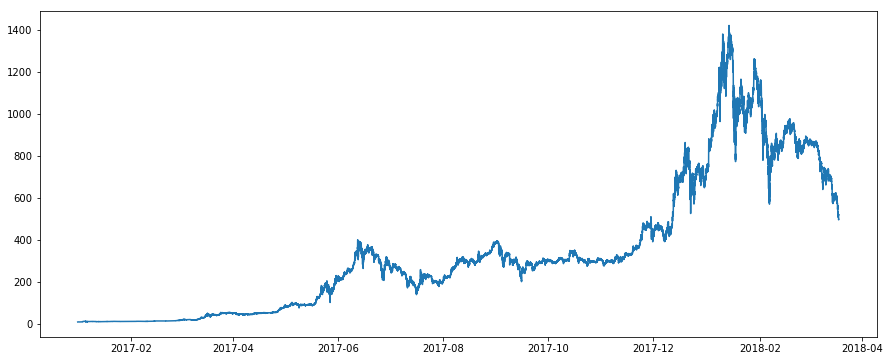

In [11]:
plt.plot(df['weightedAverage'])

In [14]:
#moyenne glissante sur une journée et test de stationnarité de la timeseries
import matplotlib.dates as dates
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=288,center=False).mean() 
    rolstd = timeseries.rolling(window=288,center=False).std()

    #Plot rolling statistics:
    fig, ax= plt.subplots()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Moyenne glissante & Standard Deviation')
   
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid()
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    plt.show(block=False)
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

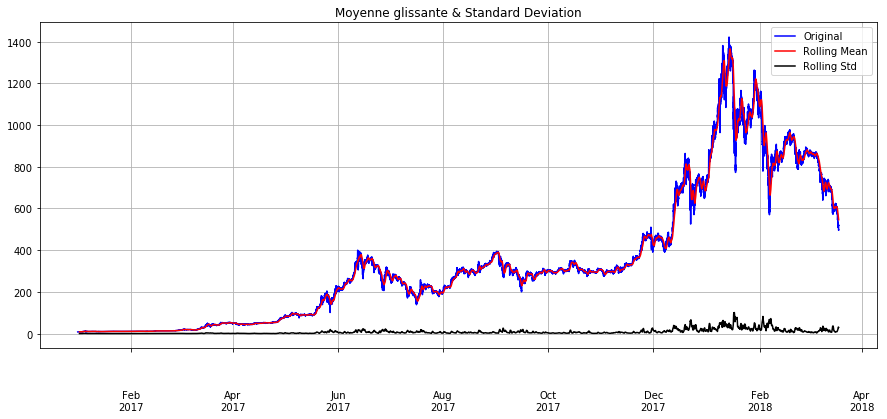

Results of Dickey-Fuller Test:
Test Statistic                     -1.327263
p-value                             0.616609
#Lags Used                         66.000000
Number of Observations Used    127077.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [15]:
test_stationarity(df['weightedAverage'])

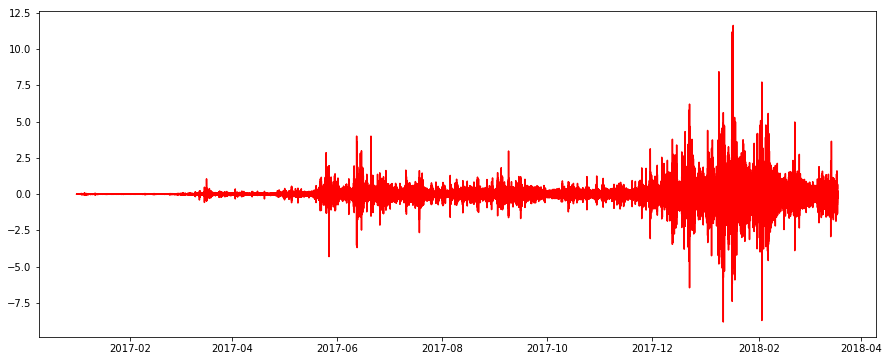

In [16]:
#Implémentation d'une ARIMA
model = ARIMA(df['weightedAverage'], order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(results_ARIMA.fittedvalues, color='red')

In [17]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log2 = pd.Series(df['weightedAverage'].ix[0], index=df['weightedAverage'].index)
predictions_ARIMA_log = predictions_ARIMA_log2.add(predictions_ARIMA_diff_cumsum,fill_value=0)

C:\Users\yahya\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


In [18]:
ts_week_log=df['weightedAverage']
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f, day=%s, diff=%f' % (yhat, obs,str(test.index[t]),(yhat-obs)*100/yhat))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

#predictions_series = pd.Series(predictions, index = t.index)

Printing Predicted vs Expected Values...


predicted=512.644024, expected=513.966064, day=2018-03-18 10:05:00, diff=-0.257887
predicted=514.158183, expected=512.849531, day=2018-03-18 10:10:00, diff=0.254523
predicted=512.532684, expected=513.999991, day=2018-03-18 10:15:00, diff=-0.286286
predicted=514.268675, expected=513.423603, day=2018-03-18 10:20:00, diff=0.164325
predicted=513.248535, expected=505.280775, day=2018-03-18 10:25:00, diff=1.552417
predicted=503.936706, expected=502.810664, day=2018-03-18 10:30:00, diff=0.223449
predicted=503.040962, expected=502.013636, day=2018-03-18 10:35:00, diff=0.204223
predicted=502.165690, expected=499.754596, day=2018-03-18 10:40:00, diff=0.480139
predicted=499.476595, expected=496.482031, day=2018-03-18 10:45:00, diff=0.599541
predicted=496.121961, expected=497.042133, day=2018-03-18 10:50:00, diff=-0.185473
predicted=497.424818, expected=501.017673, day=2018-03-18 10:55:00, diff=-0.722291
predicted=501.691094, expected=495.220756, day=2018